In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import wandb
import Neural_Lib_Flo as nlb
import wandb_library as wl 
import training_lib as tl
import torch.nn.functional as F

In [3]:
# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set the root directory
root_dir_sensorium = '/project/data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6/data'
images_path = '/project/subiculum/data/images_uint8.npy'
v1_responses_path = '/project/subiculum/data/V1_Data.mat'
sub_responses_path= '/project/subiculum/data/Post_Sub_Data.mat'

I have already run a sweep using wandb, so this won't be done again here.

In [5]:
api = wandb.Api()
run = api.run("seifertflo/V1 Training 17-06-2024/2mr3hewa")
config=run.config
v1_model=nlb.configure_model(config, 13, device)
v1_train_loader, v1_val_loader, v1_test_loader = nlb.dataloader_from_mat(images_path, v1_responses_path, 75, 125, 64)
tl.training_and_eval_with_lr(v1_model, config.get("epochs"), v1_train_loader, v1_test_loader, v1_val_loader, device, save_model=True, path_for_saving='models/v1_model.pt')

Epoch [1/50], validation correlation: 0.1081, trainloss: 0.4186
Epoch [2/50], validation correlation: 0.0921, trainloss: 0.3010
Epoch [3/50], validation correlation: 0.0874, trainloss: 0.2970
Epoch [4/50], validation correlation: 0.0845, trainloss: 0.2959
Epoch     5: reducing learning rate of group 0 to 1.0000e-02.
Epoch [5/50], validation correlation: 0.0769, trainloss: 0.2931
Epoch [6/50], validation correlation: 0.0832, trainloss: 0.2872
Early stopping triggered!

model saved as models/v1_model.pt
Test Loss: 0.3036
Test Correlation: 0.0704


We can now use the same configuration to get a rough idea of what training with the Sub Data would give:

In [6]:
sub_train_loader, sub_val_loader, sub_test_loader =nlb.dataloader_from_mat(images_path, sub_responses_path, 75, 125, 64)
sub_model=nlb.configure_model(config, 37, device)
tl.training_and_eval_with_lr(sub_model, config.get("epochs"),sub_train_loader, sub_val_loader, sub_test_loader, device, save_model=True, path_for_saving='models/sub_model.pt'), 

Epoch [1/50], validation correlation: 0.0273, trainloss: 0.7424
Epoch [2/50], validation correlation: 0.0655, trainloss: 0.4592
Epoch [3/50], validation correlation: 0.0769, trainloss: 0.4533
Epoch [4/50], validation correlation: 0.0620, trainloss: 0.4411
Epoch [5/50], validation correlation: 0.0560, trainloss: 0.4338
Epoch [6/50], validation correlation: 0.0572, trainloss: 0.4326
Epoch     7: reducing learning rate of group 0 to 1.0000e-02.
Epoch [7/50], validation correlation: 0.0663, trainloss: 0.4330
Epoch [8/50], validation correlation: 0.0710, trainloss: 0.4223
Early stopping triggered!

model saved as models/sub_model.pt
Test Loss: 0.4679
Test Correlation: 0.0619


(None,)

As one gets a correlation of ~30% for the Sensorium data, it would be helpful to understand why this is not reached for the v1 data here. 

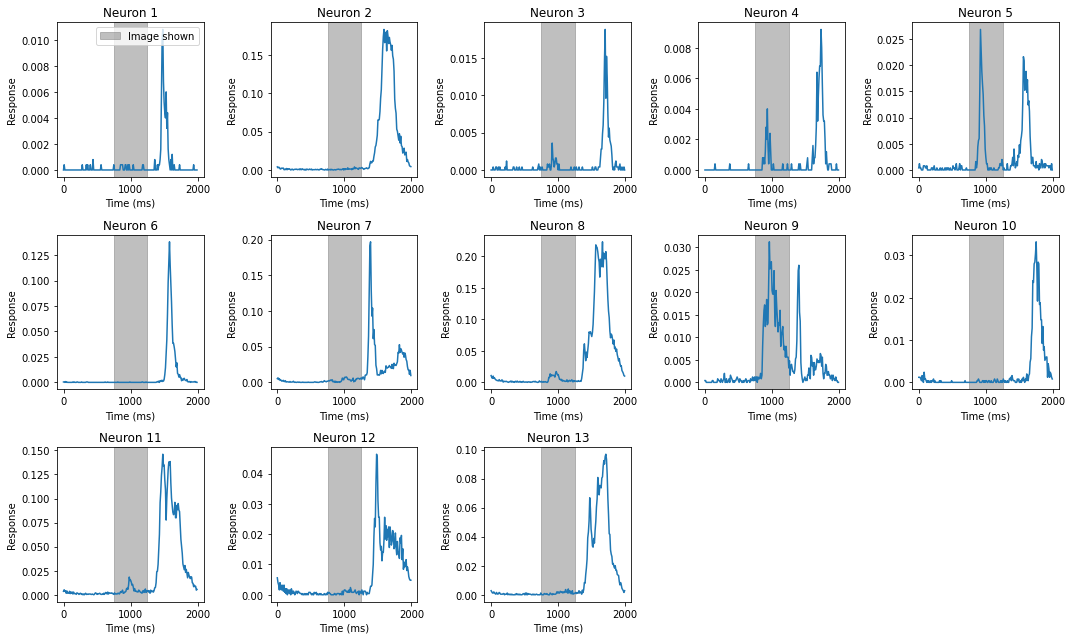

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
def plot_avrg_response(images_path, response_path):
    # Load Images to np.array
    images = np.load(images_path)

    # Load responses and preprocess them
    responses, _, _ = nlb.load_mat_file(response_path)
    responses = np.transpose(responses, (1, 2, 0))

    # Look at mean data for neurons
    responses_mean = np.mean(responses, axis=0, keepdims=True)

    # Define the number of plots
    num_plots = responses.shape[2]
    neuron_indices = range(num_plots)

    # Create a 3x5 grid of subplots
    fig, axs = plt.subplots(int(np.ceil(float(num_plots)/5.0)),5, figsize=(15, 9))
    axs = axs.flatten()  # Flatten the 2D array to 1D for easier iteration

    # Create a custom legend patch
    legend_patch = mpatches.Patch(color='gray', alpha=0.5, label='Image shown')

    # Plot each neuron data
    x = np.arange(0, 2000, 10)
    for i, neuron_index in enumerate(neuron_indices):
        if i < len(neuron_indices):  # Ensure we don't go out of bounds
            neuron_mean = responses_mean[:, :, neuron_index]
            axs[i].plot(x, neuron_mean[0, :])
            axs[i].axvspan(750, 1250, color='gray', alpha=0.5)  # Add transparent gray tile
            axs[i].set_title(f'Neuron {neuron_index + 1}')
            axs[i].set_xlabel('Time (ms)')
            axs[i].set_ylabel('Response')
            # Add the legend to the first plot only to avoid repetition
            if i == 0:
                axs[i].legend(handles=[legend_patch])

    # Remove empty subplots (if any)
    for j in range(len(neuron_indices), len(axs)):
        fig.delaxes(axs[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()
# plot_avrg_response(images_path, v1_responses_path)

The same can be done for the sub data

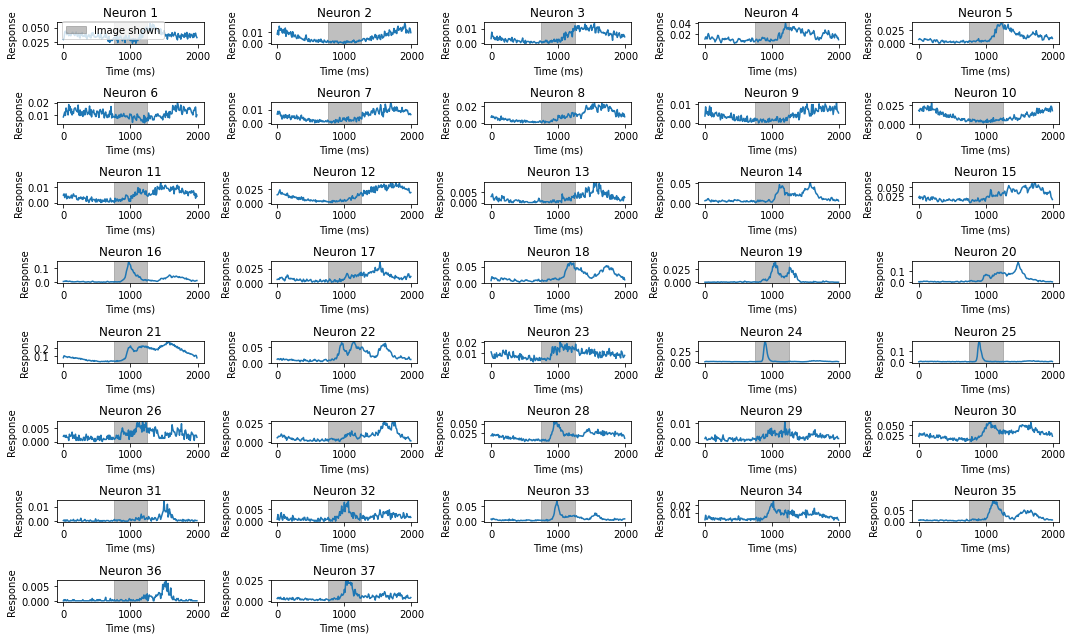

In [ ]:
plot_avrg_response(images_path, sub_responses_path)

This shows the structure of the responses.
Now Ill compute oracle of the sensorium Data to compare the best neurons to the neurons here.

In [ ]:
sensorium_train_loader, sensorium_val_loader, sensorium_test_loader = nlb.dataloader_from_npy_pretraining(root_dir_sensorium, device)
sensorium_model = nlb.ConvModel(layers=5, input_kern=11, hidden_kern=5, hidden_channels=32, output_dim=8372).to(device)
tl.training_and_eval_with_lr(sensorium_model, 100, sensorium_train_loader, sensorium_test_loader, sensorium_val_loader, device,gamma=1e-2,lr=1e-3, save_model=True, path_for_saving=("models/sens_model.pt"))

/usr/local/lib/python3.8/dist-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")


Epoch [1/100], validation correlation: 0.0451, trainloss: 0.9499
Epoch [2/100], validation correlation: 0.0502, trainloss: 0.7541
Epoch [3/100], validation correlation: 0.0522, trainloss: 0.6580
Epoch [4/100], validation correlation: 0.0546, trainloss: 0.6135
Epoch [5/100], validation correlation: 0.0609, trainloss: 0.5899
Epoch [6/100], validation correlation: 0.0654, trainloss: 0.5742
Epoch [7/100], validation correlation: 0.0707, trainloss: 0.5609
Epoch [8/100], validation correlation: 0.0723, trainloss: 0.5522
Epoch [9/100], validation correlation: 0.0680, trainloss: 0.5439
Epoch [10/100], validation correlation: 0.0848, trainloss: 0.5383
Epoch [11/100], validation correlation: 0.0889, trainloss: 0.5319
Epoch [12/100], validation correlation: 0.0900, trainloss: 0.5250
Epoch [13/100], validation correlation: 0.0958, trainloss: 0.5195
Epoch [14/100], validation correlation: 0.1021, trainloss: 0.5136
Epoch [15/100], validation correlation: 0.1041, trainloss: 0.5076
Epoch [16/100], val

In [ ]:
state_dict_sens = torch.load('models/sens_model.pt')
sensorium_model.load_state_dict(state_dict_sens)
sensorium_model.to(device)

ConvModel(
  (conv_layers): Sequential()
  (core): Sequential(
    (0): Conv2d(1, 32, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SiLU()
    (6): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): SiLU()
    (9): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): SiLU()
    (12): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): SiLU()
  )
  (readout): GaussianReadou

In [ ]:
with torch.no_grad():
    sens_val_corrs = nlb.get_correlations(sensorium_model, sensorium_val_loader, device)
best_neurons = np.argsort(-sens_val_corrs)

Now we will compute the spike triggered average (which can be seen as a first approximation of a MEI)
1. Do it by averaging over the images: implement a function for this. Advantage: Does not rely on the trained model.
2. Use the model: Here we can use random inputs to generate STAs.
3. Use the model: Compute Gradient RFs
4. Generate MEIs.

Shows the STA for the best neurons (in terms of correlation on the validation loader):
torch.Size([5994])
Processing neuron 2085...
Processing neuron 269...
Processing neuron 1085...
Processing neuron 6434...
Processing neuron 746...
Processing neuron 4665...
Processing neuron 1503...
Processing neuron 4887...
Processing neuron 1630...
Processing neuron 6876...
Processing neuron 4331...
Processing neuron 1554...


/project/subiculum/code/Neural_Lib_Flo.py:889: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


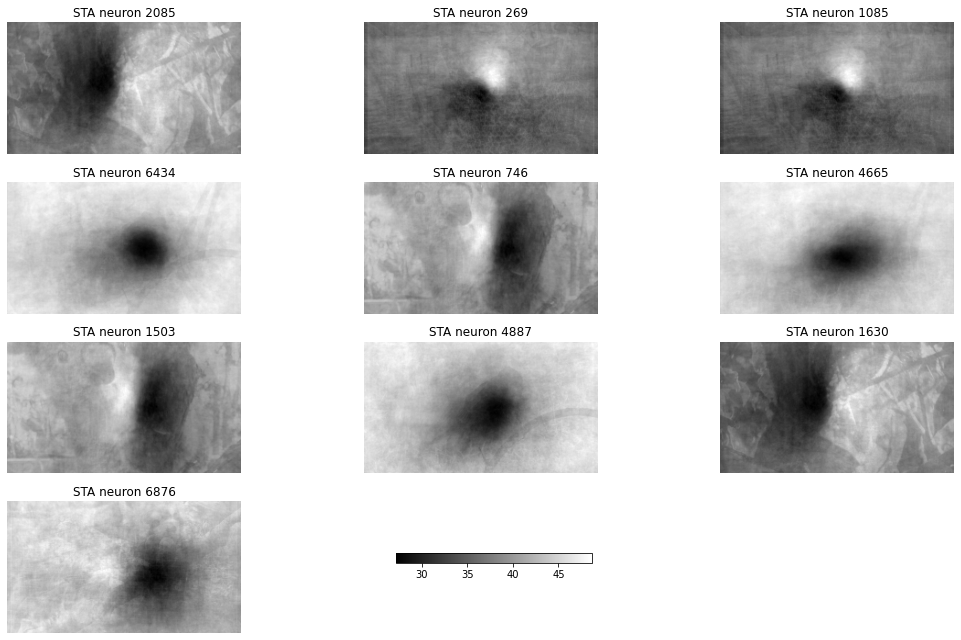

In [ ]:
nlb.sta_wo_model(device,best_neurons, root_dir_sensorium)


/project/subiculum/code/Neural_Lib_Flo.py:846: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_tensor = torch.tensor(batch, dtype=torch.float32).to(device)


torch.Size([2500, 64, 64])
torch.Size([13, 2500])


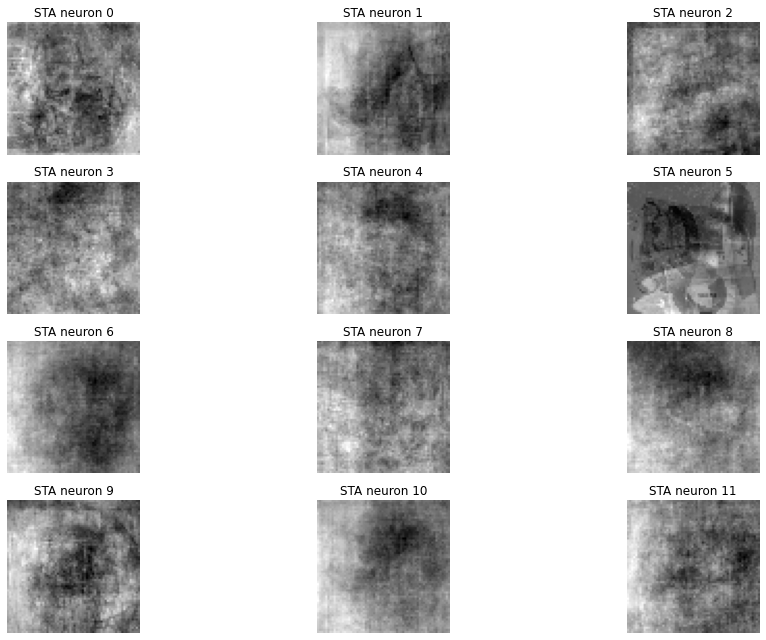

In [ ]:
neurons=[0,1,2,3,4,5,6,7,8,9,10,11,12]
nlb.sta_wo_model(device, neurons ,v1_responses_path, images_path,data_is_npy=False)

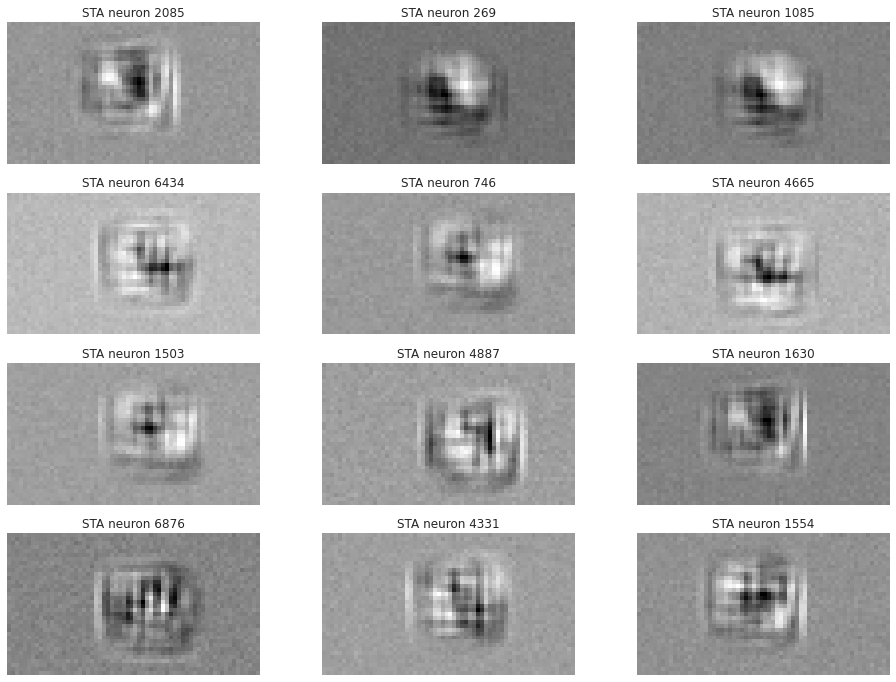

In [ ]:
nlb.STA_model_sens(sensorium_model, 'models/sens_model.pt', best_neurons)


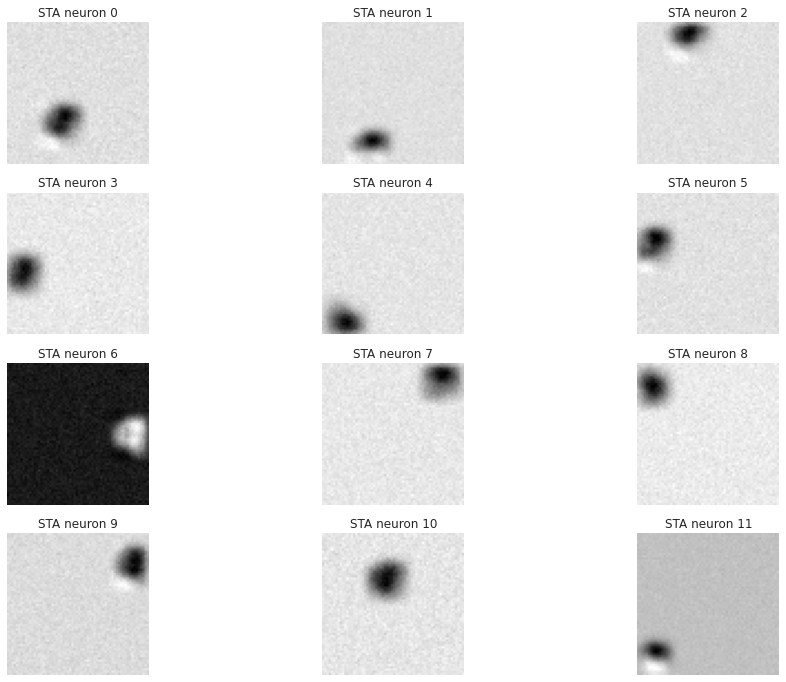

In [ ]:
nlb.STA_model(v1_model, 'models/v1_model.pt', neurons)

In [ ]:
api = wandb.Api()
run = api.run("seifertflo/V1 Training 17-06-2024/2mr3hewa")
config=run.config
sub_model=nlb.configure_model(config, 37, device)
sub_state_dict=torch.load('models/sub_model.pt')
sub_model.load_state_dict(sub_state_dict)
with torch.no_grad():
    sub_val_corrs = nlb.get_correlations(sub_model, sub_val_loader, device)
best_neurons_sub = np.argsort(-sub_val_corrs)
nlb.STA_model(sub_model, 'models/sub_model.pt', best_neurons_sub)

KeyboardInterrupt: 

/project/subiculum/code/Neural_Lib_Flo.py:846: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_tensor = torch.tensor(batch, dtype=torch.float32).to(device)


torch.Size([2500, 64, 64])
torch.Size([37, 2500])


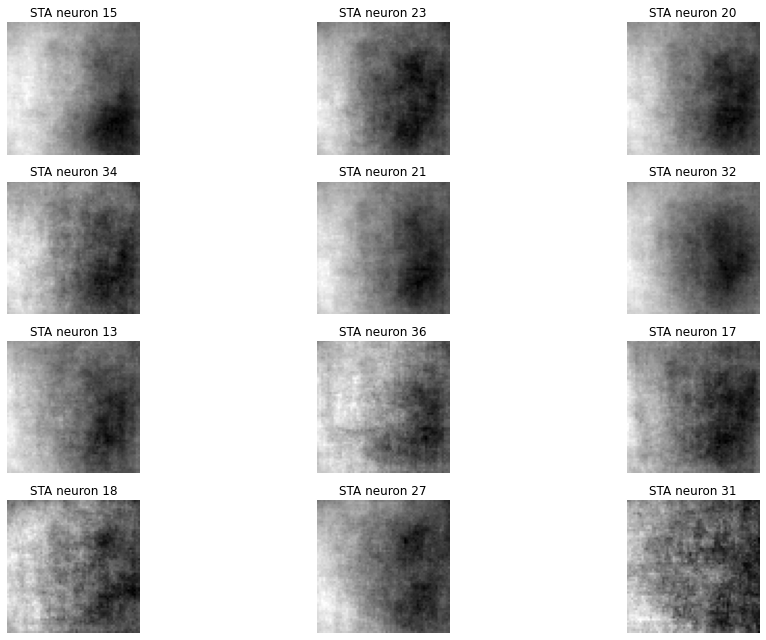

In [ ]:
nlb.sta_wo_model(device, best_neurons_sub ,sub_responses_path, images_path,data_is_npy=False)

In [ ]:
v1_model_or=nlb.configure_model(config, 13, device)
v1_train_loader_or, v1_val_loader_or, v1_test_loader_or = nlb.dataloader_from_mat(images_path, v1_responses_path, time_begin=125, time_end=200, batch_size=64)
tl.training_and_eval_with_lr(v1_model_or, config.get("epochs"), v1_train_loader_or, v1_test_loader_or, v1_val_loader_or, device, save_model=True, path_for_saving='models/v1_model_or.pt')

torch.Size([64, 128, 52, 52])
torch.Size([64, 128, 52, 52])
torch.Size([64, 128, 52, 52])
torch.Size([64, 128, 52, 52])
torch.Size([64, 128, 52, 52])
torch.Size([64, 128, 52, 52])



KeyboardInterrupt: 

The negative loss does not make any sense - it should be positive. Have not been able to find the bug yet. 

This is not great results:
1. Images shown only once, instead of 10 times per images in Sensorium -> More affected by noise.
2. Images are all natural -> Might have been useful to shows simpler images?

What can I do?
1. Different model? 
2. Pretrain? Has not worked well yet -> Have only pretrained core, and trained readout afterwards, but that might not be the best way?

In [ ]:
v1_model_or=nlb.configure_model(config, 13, device)
v1_train_loader_or, v1_val_loader_or, v1_test_loader_or = nlb.dataloader_from_mat(images_path, v1_responses_path, time_begin=125, time_end=200, batch_size=64)
tl.training_and_eval_with_lr(v1_model_or, config.get("epochs"), v1_train_loader_or, v1_test_loader_or, v1_val_loader_or, device, save_model=True, path_for_saving='models/v1_model_or.pt')

## To Dos
1. Pretrain on Sensorium data, train entire model on V1/postsub data
2. Change readout to factorization readout, train and generate STA
3. Repeat 1. with f 2.
4. Generate STA from gradient

In [16]:
v1_model_factorized = nlb.configure_model(config,13,device,False)
tl.training_and_eval_with_lr(v1_model_factorized,100,v1_train_loader, v1_test_loader, v1_val_loader, device,)


NameError: name 'config' is not defined

In [8]:
v1_model_pretrained=nlb.ConvModel(layers=5, input_kern=11, hidden_kern=5, hidden_channels=32, output_dim=8372).to(device)
v1_state_dict=torch.load('models/sens_model.pt')
v1_model_pretrained.load_state_dict(v1_state_dict)
hidden_channels=nlb.get_last_conv_out_channels(v1_model_pretrained)
v1_model_pretrained.readout=nlb.GaussianReadout(13, hidden_channels,spatial_scale=0.05, std_scale=0.2).to(device)
tl.training_and_eval_with_lr(v1_model_pretrained,100, v1_train_loader, v1_test_loader, v1_val_loader, device,lr=1e-2)

/usr/local/lib/python3.8/dist-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")


Epoch [1/100], validation correlation: -0.0027, trainloss: 0.4809
Epoch [2/100], validation correlation: 0.0291, trainloss: 0.2926
Epoch [3/100], validation correlation: 0.0408, trainloss: 0.2897
Epoch [4/100], validation correlation: 0.0429, trainloss: 0.2873
Epoch [5/100], validation correlation: 0.0432, trainloss: 0.2861
Epoch [6/100], validation correlation: 0.1114, trainloss: 0.2834
Epoch [7/100], validation correlation: 0.0960, trainloss: 0.2838
Epoch [8/100], validation correlation: 0.0552, trainloss: 0.2857
Epoch [9/100], validation correlation: 0.0363, trainloss: 0.2872
Epoch    10: reducing learning rate of group 0 to 1.0000e-03.
Epoch [10/100], validation correlation: 0.0924, trainloss: 0.2876
Epoch [11/100], validation correlation: 0.1101, trainloss: 0.2812
Early stopping triggered!

Test Loss: 0.2923
Test Correlation: 0.1064


In [33]:
api = wandb.Api()
v1_run_or = api.run("seifertflo/V1 OFF response Training 24-06-2024/tgly5e97")
v1_train_loader_or, v1_val_loader_or, v1_test_loader_or = nlb.dataloader_from_mat(images_path, v1_responses_path, time_begin=125, time_end=200, batch_size=64)
v1_or_config=v1_run_or.config
v1_or_model=nlb.configure_model(v1_or_config, 8372, device)
v1_state_dict=torch.load('/project/subiculum/code/models/v1_model_or_sens.pt')
v1_or_model.load_state_dict(v1_state_dict)
hidden_channels=nlb.get_last_conv_out_channels(v1_or_model)
v1_or_model.readout=nlb.GaussianReadout(13, hidden_channels,spatial_scale=0.19237810044779985, std_scale=0.2306692445946063).to(device)
tl.training_and_eval_with_lr(v1_or_model,100, v1_val_loader_or,v1_train_loader_or, v1_test_loader_or,device,True,0.08865963714161047,path_for_saving="/project/subiculum/code/models/v1_model_or.pt", early_stopping=False)

Epoch [1/100], validation correlation: 0.0219, trainloss: -0.0133
Epoch [2/100], validation correlation: -0.0199, trainloss: -0.1393
Epoch [3/100], validation correlation: -0.0002, trainloss: -0.1887
Epoch [4/100], validation correlation: -0.0080, trainloss: -0.2613
Epoch     5: reducing learning rate of group 0 to 8.8660e-03.
Epoch [5/100], validation correlation: -0.0046, trainloss: -0.2568
Epoch [6/100], validation correlation: 0.0132, trainloss: -0.2740
Epoch [7/100], validation correlation: 0.0258, trainloss: -0.2166
Epoch [8/100], validation correlation: 0.0330, trainloss: -0.2904
Epoch [9/100], validation correlation: 0.0383, trainloss: -0.2734
Epoch [10/100], validation correlation: 0.0407, trainloss: -0.2966
Epoch [11/100], validation correlation: 0.0407, trainloss: -0.3002
Epoch [12/100], validation correlation: 0.0411, trainloss: -0.2928
Epoch [13/100], validation correlation: 0.0475, trainloss: -0.2973
Epoch [14/100], validation correlation: 0.0514, trainloss: -0.3125
Epoch

/project/subiculum/code/Neural_Lib_Flo.py:904: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  responses = torch.tensor(np.sum(responses[:,:, index_start:index_end], axis=2).astype('float32')).to(device)


torch.Size([2500, 64, 64])
torch.Size([13, 2500])


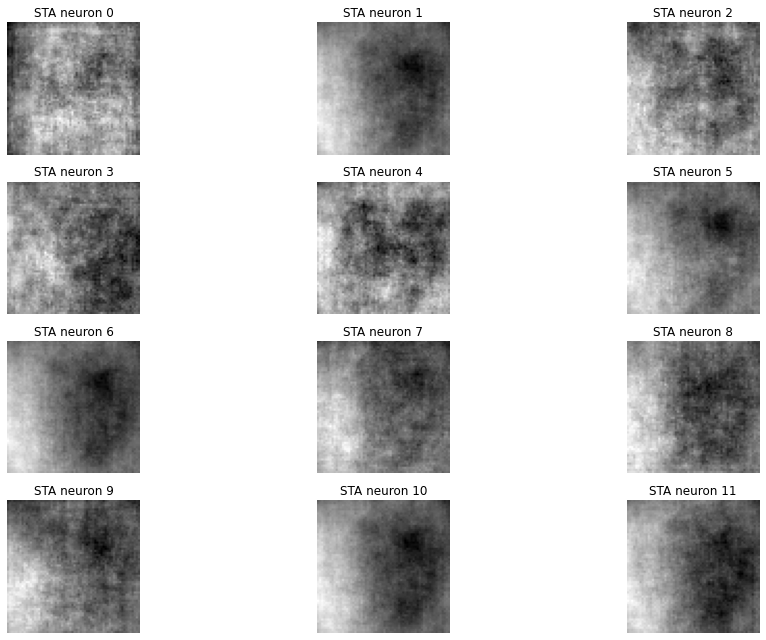

In [34]:
neurons=[0,1,2,3,4,5,6,7,8,9,10,11,12]
nlb.sta_wo_model(device, neurons ,v1_responses_path, images_path,data_is_npy=False,index_start=125,index_end=200)

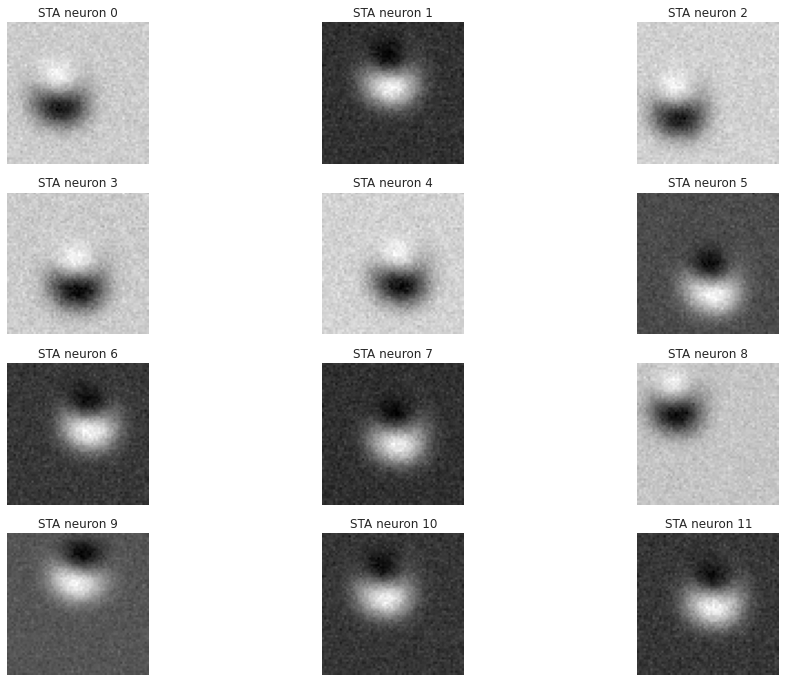

In [35]:
nlb.STA_model(v1_or_model, '/project/subiculum/code/models/v1_model_or.pt', neurons)

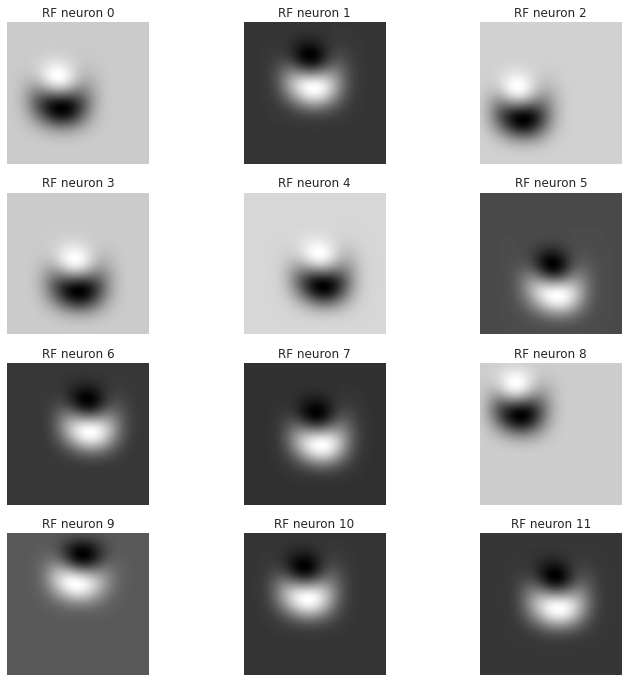

In [36]:
nlb.gradientRF(v1_or_model, '/project/subiculum/code/models/v1_model_or.pt', neurons,device)

/usr/local/lib/python3.8/dist-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")


Epoch [1/20], validation correlation: 0.0369, trainloss: 0.4129
Epoch [2/20], validation correlation: 0.0520, trainloss: 0.2410
Epoch [3/20], validation correlation: 0.0526, trainloss: 0.3541
Epoch [4/20], validation correlation: 0.0471, trainloss: 0.3089
Epoch [5/20], validation correlation: 0.0562, trainloss: 0.2842
Epoch [6/20], validation correlation: 0.0493, trainloss: 0.3580
Epoch [7/20], validation correlation: 0.0533, trainloss: 0.4295
Epoch [8/20], validation correlation: 0.0589, trainloss: 0.4162
Epoch [9/20], validation correlation: 0.0699, trainloss: 0.4844
Epoch [10/20], validation correlation: 0.0736, trainloss: 0.4614
Epoch [11/20], validation correlation: 0.0736, trainloss: 0.4435
Epoch [12/20], validation correlation: 0.0796, trainloss: 0.4823
Epoch [13/20], validation correlation: 0.0755, trainloss: 0.3803
Epoch [14/20], validation correlation: 0.0764, trainloss: 0.4333
Epoch [15/20], validation correlation: 0.0885, trainloss: 0.4593
Epoch [16/20], validation correlat

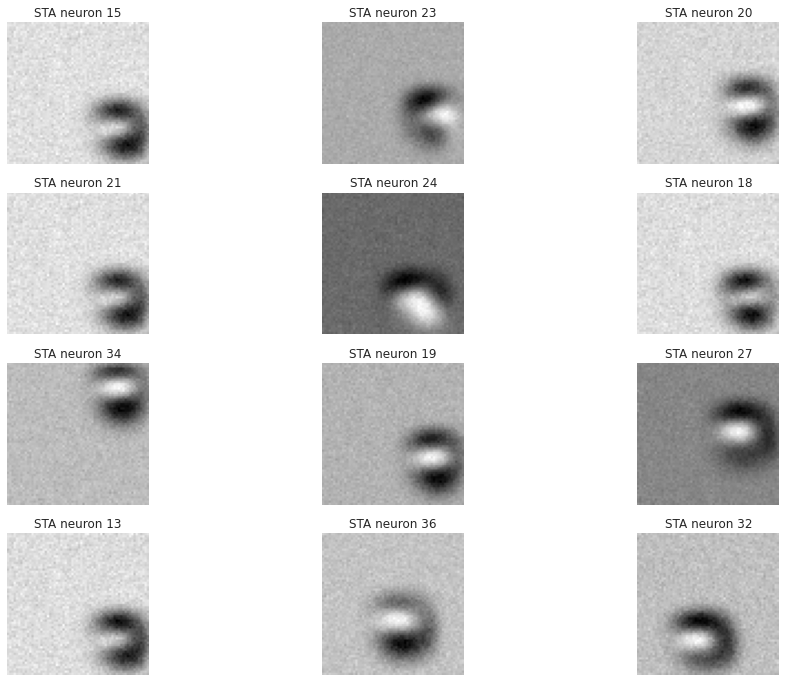

In [27]:
sub_train_loader, sub_val_loader, sub_test_loader =nlb.dataloader_from_mat(images_path, sub_responses_path, 75, 125, 64)
api = wandb.Api()
sub_run = api.run("seifertflo/Sub ON response Training 26-06-2024/wovxrvu7")
sub_config=sub_run.config
sub_model=nlb.configure_model(sub_config, 37, device)
tl.training_and_eval_with_lr(sub_model, sub_config.get("epochs"),sub_train_loader, sub_val_loader, sub_test_loader, device, save_model=True, path_for_saving='models/sub_model.pt'), 
with torch.no_grad():
    sub_val_corrs = nlb.get_correlations(sub_model, sub_val_loader, device)
best_neurons_sub = np.argsort(-sub_val_corrs)
nlb.STA_model(sub_model, 'models/sub_model.pt', best_neurons_sub)

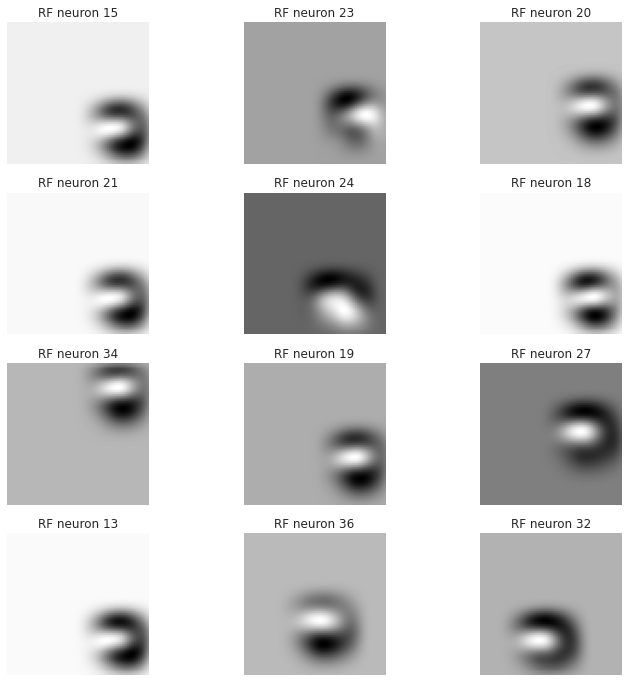

In [30]:
nlb.gradientRF(sub_model,'models/sub_model.pt', best_neurons_sub, device)

/project/subiculum/code/Neural_Lib_Flo.py:856: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_tensor = torch.tensor(batch, dtype=torch.float32).to(device)


torch.Size([2500, 64, 64])
torch.Size([37, 2500])


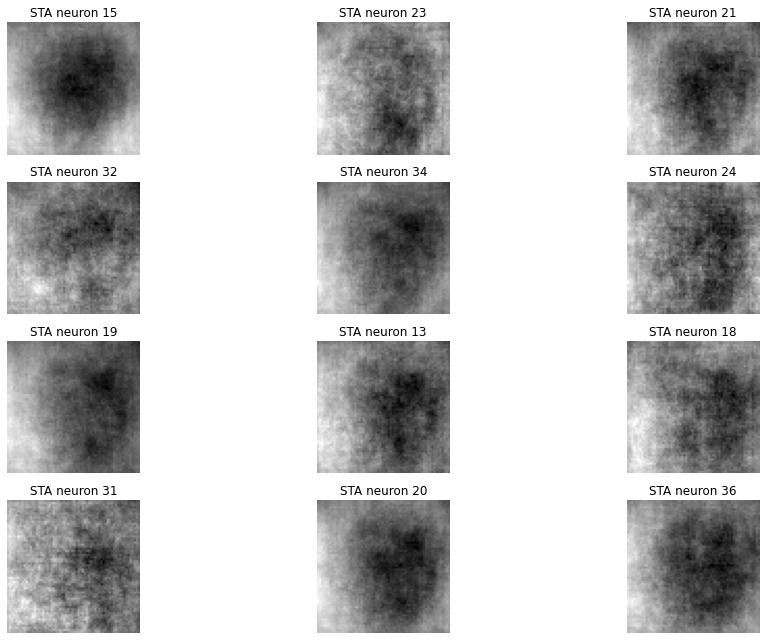

In [6]:
nlb.sta_wo_model(device, best_neurons_sub, sub_responses_path, images_path, False, 125,200)

ConvModel(
  (conv_layers): Sequential()
  (core): Sequential(
    (0): Conv2d(1, 32, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): Conv2d(32, 32, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SiLU()
    (6): Conv2d(32, 32, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): SiLU()
    (9): Conv2d(32, 32, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): SiLU()
    (12): Conv2d(32, 32, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): SiLU()
  )
  (readout): Gaussi

/usr/local/lib/python3.8/dist-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")


Epoch [1/100], validation correlation: 0.0032, trainloss: -0.0626
Epoch [2/100], validation correlation: 0.0058, trainloss: -0.2132
Epoch [3/100], validation correlation: 0.0127, trainloss: 0.1714
Epoch [4/100], validation correlation: 0.0222, trainloss: 0.1859
Epoch [5/100], validation correlation: 0.0280, trainloss: 0.2275
Epoch [6/100], validation correlation: 0.0345, trainloss: -0.0586
Epoch [7/100], validation correlation: 0.0312, trainloss: 0.1846
Epoch [8/100], validation correlation: 0.0316, trainloss: 0.1928
Epoch [9/100], validation correlation: 0.0367, trainloss: -0.2003
Epoch [10/100], validation correlation: 0.0494, trainloss: 0.0659
Epoch [11/100], validation correlation: 0.0330, trainloss: 0.0705
Epoch [12/100], validation correlation: 0.0478, trainloss: 0.0123
Epoch [13/100], validation correlation: 0.0411, trainloss: -0.0079
Epoch [14/100], validation correlation: 0.0518, trainloss: -0.0195
Epoch [15/100], validation correlation: 0.0447, trainloss: -0.0065
Epoch [16/10

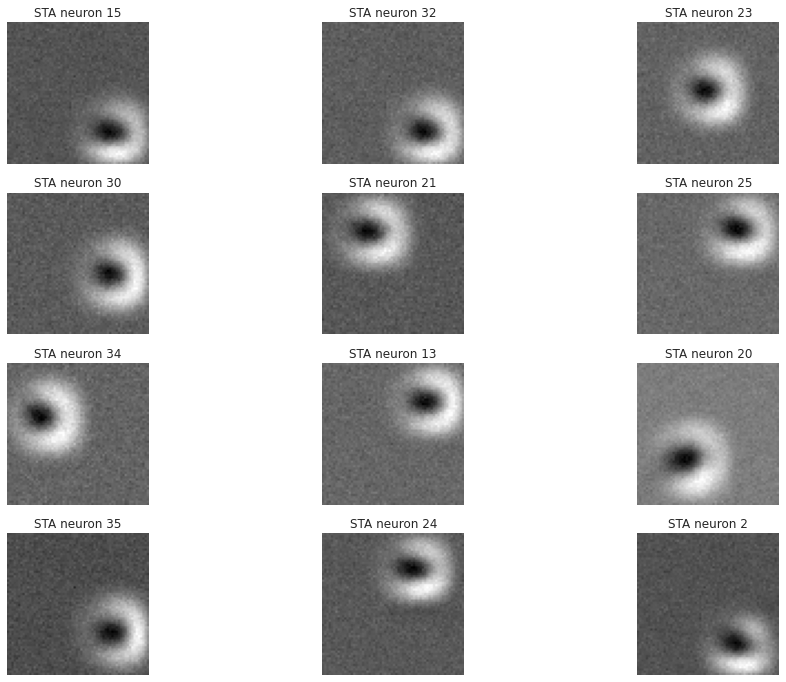

In [31]:
sub_train_loader_or, sub_val_loader_or, sub_test_loader_or =nlb.dataloader_from_mat(images_path, sub_responses_path, 125, 200, 64)
api = wandb.Api()
sub_run = api.run("seifertflo/Sub OFF response Training 24-06-2024/bp5jezif")
sub_config=sub_run.config
sub_model=nlb.configure_model(sub_config, 37, device).to(device)
print(sub_model)
tl.training_and_eval_with_lr(sub_model, 100,sub_train_loader_or, sub_val_loader_or, sub_test_loader_or, device, save_model=True, path_for_saving='models/sub_model_or.pt', early_stopping=False), 
with torch.no_grad():
    sub_val_corrs = nlb.get_correlations(sub_model, sub_val_loader_or, device)
best_neurons_sub = np.argsort(-sub_val_corrs)
nlb.STA_model(sub_model, 'models/sub_model_or.pt', best_neurons_sub)

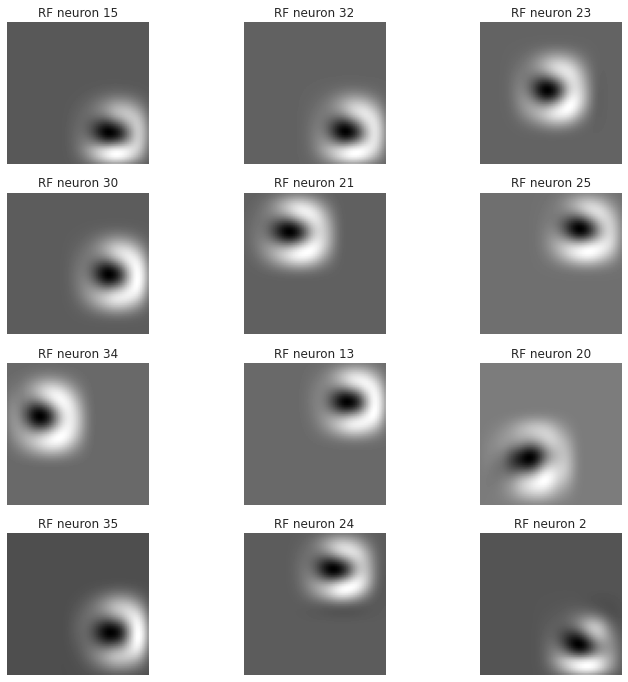

In [32]:
nlb.gradientRF(sub_model,'models/sub_model_or.pt', best_neurons_sub, device)

In [9]:
inputs, _ = next(iter(sub_train_loader))
print(inputs.shape)

torch.Size([64, 1, 64, 64])


In [15]:
sub_train_loader_or, sub_val_loader_or, sub_test_loader_or =nlb.dataloader_from_mat(images_path, sub_responses_path, 125, 200, 64)
api = wandb.Api()
run = api.run("seifertflo/Sub ON response Training 26-06-2024/wovxrvu7")
config=run.config
sub_model=nlb.configure_model(config, 37, device)
sub_model.readout= nlb.FullFactorized2d((128, 40, 40),37,False).to(device)
print(sub_model)
tl.training_and_eval_with_lr(sub_model,100,sub_train_loader_or, sub_test_loader_or, sub_val_loader_or, device,True, path_for_saving='models/sub_model_factorized_or.pt',early_stopping=False)
with torch.no_grad():
    sub_val_corrs = nlb.get_correlations(sub_model, sub_val_loader_or, device)
best_neurons_sub_factorized = np.argsort(-sub_val_corrs)


ConvModel(
  (conv_layers): Sequential()
  (core): Sequential(
    (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): Conv2d(128, 128, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SiLU()
    (6): Conv2d(128, 128, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): SiLU()
    (9): Conv2d(128, 128, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): SiLU()
    (12): Conv2d(128, 128, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): SiLU()
  )
  (read

/usr/local/lib/python3.8/dist-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")


Epoch [1/100], validation correlation: 0.0042, trainloss: 93.8687
Epoch [2/100], validation correlation: 0.0093, trainloss: 28.8619
Epoch [3/100], validation correlation: 0.0061, trainloss: 19.6457
Epoch [4/100], validation correlation: -0.0048, trainloss: 14.1328
Epoch [5/100], validation correlation: 0.0106, trainloss: 12.0356
Epoch [6/100], validation correlation: 0.0211, trainloss: 11.8999
Epoch [7/100], validation correlation: 0.0100, trainloss: 12.9146
Epoch [8/100], validation correlation: 0.0086, trainloss: 11.8388
Epoch [9/100], validation correlation: 0.0090, trainloss: 11.6645
Epoch    10: reducing learning rate of group 0 to 1.0000e-02.
Epoch [10/100], validation correlation: -0.0023, trainloss: 11.1296
Epoch [11/100], validation correlation: 0.0025, trainloss: 2.1957
Epoch [12/100], validation correlation: 0.0175, trainloss: 1.6856
Epoch [13/100], validation correlation: 0.0206, trainloss: 1.4298
Epoch    14: reducing learning rate of group 0 to 1.0000e-03.
Epoch [14/100],

RuntimeError: Error(s) in loading state_dict for ConvModel:
	Missing key(s) in state_dict: "readout._features", "readout.spatial". 
	Unexpected key(s) in state_dict: "readout.pos_mean", "readout.pos_sqrt_cov", "readout.linear", "readout.bias". 

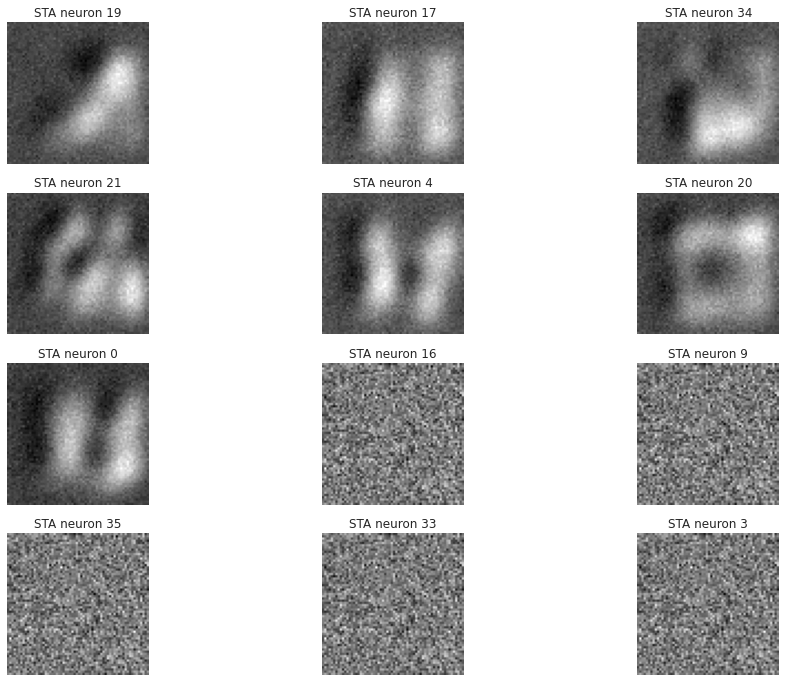

In [16]:
nlb.STA_model(sub_model, 'models/sub_model_factorized_or.pt', best_neurons_sub_factorized)